In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import statsmodels.formula.api as smf

from linearmodels import PanelOLS
from sklearn.linear_model import Ridge, Lasso
import os
import math
from datetime import date
from functools import partial

from scipy.stats import lognorm
from scipy.stats import norm
from scipy.optimize import fsolve
from tqdm import tqdm

%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': '16'})
import warnings; warnings.simplefilter('ignore')

In [ ]:
!pip install statsmodels

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# Linear Regression

In [3]:
organic_strawb = pd.read_csv("data/organic_strawberry.csv")

In [4]:
organic_strawb.head(5)

,parent_code,dma_code,store_code_uc,week_end,market_index,q_own,q_other,s_own,s_other,p_own,p_other,p_out,p_out_avg,x_own,x_other,x_month,x_usda_lettuce,x_usda_lettuce_2,x_outf,x_outf_2,income,z_own,z_other,z_out,usda,p_change,spot_own,spot_other,p_own_nonn,p_other_nonn,dummies_parent_1,dummies_parent_2,dummies_parent_3,dummies_parent_4,dummies_parent_5,dummies_parent_6,dummies_parent_7,dummies_parent_8,dummies_parent_9
0,32,807,19978,20140104,1,1280,7856.0,0.046915,0.287938,0.475117,0.379597,0.898406,0.827025,0.859946,0.7,0.7,0.159946,0.159946,0.806758,0,0.281392,0.630051,0.452683,0.410149,1,0,0.304688,0.138777,0.311875,0.249375,0,1,0,0,0,0,0,0,0
1,32,807,19978,20140111,2,1536,9280.0,0.032934,0.198979,0.475117,0.368789,0.735888,0.766987,0.859946,0.7,0.7,0.159946,0.159946,0.000580,0,0.281392,0.628985,0.415960,0.139835,1,0,0.304688,0.138219,0.311875,0.242303,0,1,0,0,0,0,0,0,0
2,32,807,19978,20140118,3,1776,7888.0,0.043361,0.192587,0.475117,0.379597,0.788804,0.795829,0.859946,0.7,0.7,0.159946,0.159946,0.204057,0,0.281392,0.626724,0.437121,0.214594,1,0,0.281250,0.144980,0.311875,0.249375,0,1,0,0,0,0,0,0,0
3,32,807,19978,20140125,4,1248,16624.0,0.022692,0.302272,0.475117,0.363137,0.838224,0.812304,0.859946,0.7,0.7,0.159946,0.159946,0.000000,0,0.281392,0.627668,0.407154,0.205855,1,0,0.242188,0.140061,0.311875,0.238605,0,1,0,0,0,0,0,0,0
4,32,807,19978,20140201,5,1760,12656.0,0.041835,0.300835,0.413648,0.296287,0.826647,0.807428,0.859946,0.7,0.7,0.159946,0.159946,0.365215,0,0.281392,0.617990,0.359689,0.229973,1,1,0.203125,0.120674,0.271655,0.194864,0,1,0,0,0,0,0,0,0


In [5]:
organic_strawb.columns

Index(['parent_code', 'dma_code', 'store_code_uc', 'week_end', 'market_index',
       'q_own', 'q_other', 's_own', 's_other', 'p_own', 'p_other', 'p_out',
       'p_out_avg', 'x_own', 'x_other', 'x_month', 'x_usda_lettuce',
       'x_usda_lettuce_2', 'x_outf', 'x_outf_2', 'income', 'z_own', 'z_other',
       'z_out', 'usda', 'p_change', 'spot_own', 'spot_other', 'p_own_nonn',
       'p_other_nonn', 'dummies_parent_1', 'dummies_parent_2',
       'dummies_parent_3', 'dummies_parent_4', 'dummies_parent_5',
       'dummies_parent_6', 'dummies_parent_7', 'dummies_parent_8',
       'dummies_parent_9'],
      dtype='object')

In [7]:
smf.ols?

In [6]:
# simples regression 

results = smf.ols('s_own ~ p_own + p_other + p_out', data=organic_strawb).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  s_own   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     2987.
Date:                Mon, 29 Aug 2022   Prob (F-statistic):               0.00
Time:                        11:53:48   Log-Likelihood:                 58067.
No. Observations:               38800   AIC:                        -1.161e+05
Df Residuals:                   38796   BIC:                        -1.161e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1349      0.003     43.891      0.0

## Dealing with FE

In [8]:
# remove fixed effects
organic_strawb = organic_strawb.set_index(['store_code_uc','week_end'])

mod = PanelOLS(organic_strawb.s_own, organic_strawb[['p_own', 'p_other', 'p_out'] ], 
               entity_effects=True)

res = mod.fit(cov_type='clustered', cluster_entity=True)
res

Dep. Variable:,s_own,R-squared:,0.1917
Estimator:,PanelOLS,R-squared (Between):,-3.3732
No. Observations:,38800,R-squared (Within):,0.1917
Date:,"Mon, Aug 29 2022",R-squared (Overall):,-2.2676
Time:,11:57:19,Log-likelihood,6.569e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2990.8
Entities:,965,P-value,0.0000
Avg Obs:,40.207,Distribution:,"F(3,37832)"
Min Obs:,1.0000,,
Max Obs:,44.000,F-statistic (robust):,412.79


In [9]:
organic_strawb = organic_strawb.reset_index()

## Lasso

In [10]:
# what if we are facing a problem where we don't really know the meaning of the data
# and trying to summarise a relationship in a few key variables
# one can use LASSO (L1 regularisation) for that purpose

X_columns = [  'p_own' , 'p_other', 'p_out',
               'p_out_avg', 'x_own', 'x_other', 'x_month', 'x_usda_lettuce',
               'x_usda_lettuce_2', 'x_outf', 'x_outf_2', 'income', 'z_own', 'z_other',
               'z_out',  'p_change', 'spot_own', 'spot_other', 'p_own_nonn',
               'p_other_nonn' ,'dummies_parent_1', 'dummies_parent_2',
               'dummies_parent_3', 'dummies_parent_4', 'dummies_parent_5',
               'dummies_parent_6', 'dummies_parent_7', 'dummies_parent_8',
               'dummies_parent_9'
            ]

y_column = ['s_own']

X, y = organic_strawb[X_columns].values, organic_strawb[y_column].values 

# define model
model = Lasso(alpha=0.00005)
# fit model
model = model.fit(X, y)

print(model.coef_)

# some variables can potentially be dropped
# 

[-2.27531211e-01  5.36022416e-02 -2.38251651e-02  4.31070267e-01
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  9.35788755e-02
  5.40168181e-16  1.43352798e-02  0.00000000e+00  3.93571921e-02
 -1.27720246e-01  1.65789673e-01  0.00000000e+00  1.86958234e-03
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -2.46101097e-02  2.99555554e-02  4.80464812e-02  0.00000000e+00
  3.77089306e-02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -5.59596439e-03]


# Simple Multiprocessing

Let's say we want to estimate $\pi$ via simulations

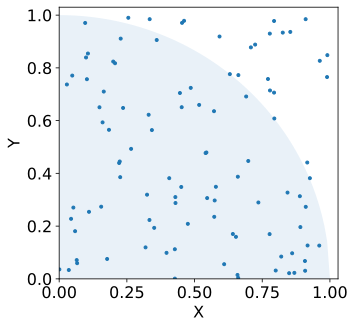

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(5,5))
x = np.linspace(0,1,100)
plt.fill_between(x, np.sqrt(1-x**2),0,alpha=0.1)
plt.xlim(0,1.03);plt.ylim(0,1.03);plt.xlabel('X');plt.ylabel('Y');

x = np.random.random(size=100)
y = np.random.random(size=100)

plt.plot(x,y,marker='.',linestyle='None');

In [12]:
bar = lambda x: x**2
foo = [1, 2, 3, 10, 110]

In [13]:
# (Very) inefficient way to define a map function
def my_map(function, array):
    # create a container for the results
    output = []

    # loop over each element
    for element in array:
        
        # add the intermediate result to the container
        output.append(function(element))
    
    # return the now-filled container
    return output

# python has its own map function

list(map(bar, foo))


[1, 4, 9, 100, 12100]

In [12]:
def pi_mc(seed):
    
    num_trials = 50000
    counter = 0
    np.random.seed(seed) # to make the results replicable
    
    for j in range(num_trials):
        
        x_val = np.random.random_sample()
        y_val = np.random.random_sample()

        radius = x_val**2 + y_val**2

        if radius < 1:
            counter += 1
            
    return 4*counter/num_trials # remember that for 1d circle its' area is pi*r and we are working with 1/4th

In [13]:
%%timeit
pi_mc(1)

33.6 ms ± 308 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%timeit
seed_array = list(range(16)) # my cpu count
result = list(map(pi_mc, seed_array))

570 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
# note that multiprocessing is the standard library but for some reason it works poorly in my jupyter
import multiprocess

In [19]:
%%timeit
seed_array = list(range(16))
with multiprocess.Pool(processes=16) as pool:
    result = pool.map(pi_mc, seed_array)
    

146 ms ± 3.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Fixed Point Problem

We can even solve games with the help of python!

In [20]:
###############################################
###############################################
###############################################
############## Create Data  ################### 
###############################################
###############################################
###############################################

# params
beta_1 = 1
beta_2_mean = 4
beta_3_mean = 4

N_goods = 4
N_firms = 4
T_number_of_markets = 300 

gamma = np.array([0.5, 0.25])
alpha = -2

rnd_seed = 2020

NS = 100 # number of simulation in the integral, determines the computation time of the code below
Number_of_cpu = os.cpu_count()//2

# data
np.random.seed(rnd_seed-3)

X_obs_good_quality = np.random.normal(size = N_goods*T_number_of_markets).reshape((N_goods, T_number_of_markets))
X_obs_good_quality = np.abs(X_obs_good_quality)

W_obs_marg_costs = np.random.normal(size = N_goods*T_number_of_markets).reshape((N_goods, T_number_of_markets))
W_obs_marg_costs = np.abs(W_obs_marg_costs)

U_unobs_char = np.random.multivariate_normal(mean = [0,0],cov = [[1,0.25],[0.25,1]], 
                                             size = (N_goods,T_number_of_markets))

dummy_satelite = np.zeros((N_goods, T_number_of_markets))
dummy_satelite[:2,:] = 1 

dummy_wire = np.zeros((N_goods, T_number_of_markets))
dummy_wire[2:,:] = 1

ksi_unobs_good_char = U_unobs_char[:,:,0]
omega_unobs_firm_char = U_unobs_char[:,:,1]


Marg_costs = np.exp(gamma[0]+gamma[1]*W_obs_marg_costs+omega_unobs_firm_char/8)
Marg_costs_index = 4

del U_unobs_char

whole_data_merged = pd.DataFrame({ 'X': np.ravel(X_obs_good_quality), 'W' : np.ravel(W_obs_marg_costs) ,
                              'ksi' : np.ravel(ksi_unobs_good_char), 'omega' : np.ravel(omega_unobs_firm_char),
                             'dummy_satelite':np.ravel(dummy_satelite), 'dummy_wire':np.ravel(dummy_wire),
                             'marginal_costs': np.ravel(Marg_costs)})

whole_data_merged['Firm'] = 0
whole_data_merged['Market_id'] = 0
market_id_list = list(range(T_number_of_markets))

for i in range(N_firms):
    whole_data_merged['Firm'].iloc[T_number_of_markets*i:T_number_of_markets*(i+1)] = 'Firm'+' '+ str(i+1)
    whole_data_merged['Market_id'].iloc[T_number_of_markets*i:T_number_of_markets*(i+1)] = market_id_list
    



In [21]:
whole_data_merged

,X,W,ksi,omega,dummy_satelite,dummy_wire,marginal_costs,Firm,Market_id
0,1.022945,2.024562,1.631751,0.342806,1.0,0.0,2.854770,Firm 1,0
1,0.140398,0.721423,-0.181261,-1.742619,1.0,0.0,1.588084,Firm 1,1
2,0.199092,0.865318,-0.704876,-0.172203,1.0,0.0,2.003317,Firm 1,2
3,0.573476,0.157585,-0.369596,1.315796,1.0,0.0,2.021563,Firm 1,3
4,0.394578,0.997968,-0.735168,-0.203733,1.0,0.0,2.062720,Firm 1,4
...,...,...,...,...,...,...,...,...,...
1195,0.330362,0.403904,-0.747807,0.150972,0.0,1.0,1.858645,Firm 4,295
1196,0.044665,0.911702,1.351801,1.394011,0.0,1.0,2.464963,Firm 4,296
1197,0.158749,0.402784,0.647426,-0.180081,0.0,1.0,1.782802,Firm 4,297
1198,2.452962,0.621929,1.042851,-0.055499,0.0,1.0,1.912756,Firm 4,298


In [22]:
###############################################
###############################################
###############################################
################ Functions #################### 
###############################################
###############################################
###############################################


def shares_for_market_t(s, data_tmp): # assume that prices for this particular market are given
                                                    # beta_2, beta_3 - consumer level constants with s
                                                    # data_tmp contains demand-market level vars and
                                                    
    
    # unpack inputs of the function
    prices, beta_2, beta_3 = s[0], s[1], s[2]
    X, ksi, dummy_sat, dummy_wr = data_tmp[0], data_tmp[1], data_tmp[2], data_tmp[3]
    
    # i = (i,j)
    # calculate deltas, shares, and derivatives
    delta_i =  beta_1*X + beta_2*dummy_sat + beta_3*dummy_wr + alpha*prices + ksi # vector of dimension of number of goods
    
    shares_numerator = np.exp(delta_i)
    shares_denomerator = 1 + np.sum(np.exp(delta_i))
    shares_i = shares_numerator/shares_denomerator
    
    
    shares_derivative_i_i = alpha*(shares_i - shares_i**2)
    shares_derivative_i_j = -alpha*(shares_i.reshape(1,N_goods)*shares_i.reshape(N_goods,1))
    
    return shares_i, shares_derivative_i_i, shares_derivative_i_j


def monte_carlo_shares_and_derivs(prices, data_tmp, N_sim = NS): # function should take only randomized betas as coeffs, NS - number of simlutaions
    
    J = prices.shape[0]
    
    np.random.seed(rnd_seed)
    beta_2_i = beta_2_mean + np.random.normal(size = N_sim)
    beta_3_j = beta_3_mean + np.random.normal(size = N_sim)
    
    # reshaping data to input in the function
    
    beta_2_i = np.ravel(np.tile(beta_2_i, N_sim))
    beta_3_j = np.ravel(np.tile(beta_3_j.reshape((N_sim,1)), N_sim))
    
    prices_long = (np.tile(prices, N_sim*N_sim)).reshape(N_sim*N_sim, J)
    beta_data_combined = zip(prices_long, beta_2_i, beta_3_j)

    # vector of prices first argument = ([1,23,34,54],[1,23,34,54],...])

    
    integrand_i_j = [shares_for_market_t(s, data_tmp) for s in beta_data_combined]
    
    
    integrand_i_j_shares = np.array([s[0] for s in integrand_i_j])
    integrand_i_j_derivatives = np.array([s[1] for s in integrand_i_j])
    integrand_i_j_cross_derivatives = np.array([s[2] for s in integrand_i_j])
    
    
    #debugging
    #print(integrand_i_j_shares.shape)
    #print(integrand_i_j_derivatives.shape)
    #print(integrand_i_j_cross_derivatives.shape)
    
    M_C_integral_shares = (1/(N_sim)**2)*(np.sum(integrand_i_j_shares, axis = 0))
    M_C_integral_derivatives = (1/(N_sim)**2)*(np.sum(integrand_i_j_derivatives, axis = 0))
    M_C_cross_derivatives = (1/(N_sim)**2)*(np.sum(integrand_i_j_cross_derivatives, axis = 0))
#     print(M_C_cross_derivatives.shape)
    
    return M_C_integral_shares, M_C_integral_derivatives, M_C_cross_derivatives
    

# this is the equilibrium equation - prices are equal to marginal costs plus some demand component
def functional_input_for_fsolve(prices, data_tmp):
    
    Monte_Carlo_Results = monte_carlo_shares_and_derivs(prices, data_tmp[:Marg_costs_index])
    marginal_costs = data_tmp[Marg_costs_index]
    
    
    VV = prices - marginal_costs + Monte_Carlo_Results[0]/(Monte_Carlo_Results[1])
    
    return VV




def price_solver_fsolve_for_market_t(data_tmp):
    
    J = data_tmp[0].shape[0]
#     print(J)
    initial_guess = np.ones(J)
    prices_final, _, ier, msg = fsolve(functional_input_for_fsolve, initial_guess, data_tmp, full_output= True )
    
    if ier == 0:
        print('No Solution Found')
        print(msg)
        
    return prices_final

def multiprocessed_price_solver_fsolve(t):
    data_t = [X_obs_good_quality[:,t],ksi_unobs_good_char[:,t], 
                        dummy_satelite[:,t] ,dummy_wire[:,t], Marg_costs[:,t]]
            
    results_t = price_solver_fsolve_for_market_t(data_t)
    
    return results_t

def price_generation(fixed_point_algo = False):
    
        
    with Pool(processes = Number_of_cpu) as p:
        simulated_prices = list(tqdm(p.imap(multiprocessed_price_solver_fsolve,
                                                    range(T_number_of_markets)), total = T_number_of_markets))
    p.close()
            
        
    simulated_prices = np.array(simulated_prices)
    
    return simulated_prices

In [ ]:
# takes approx 4 minutes on 16 cores
simulated_price_data = price_generation()

 50%|█████     | 150/300 [02:51<01:37,  1.54it/s]

# A Simple Web Scrapper

In [ ]:
# get the source
source = urllib.request.urlopen('https://pythonprogramming.net/parsememcparseface/').read()
soup = bs.BeautifulSoup(source,'lxml')

# title of the page
print(soup.title)

# get attributes:
print(soup.title.name)

# get values:
print(soup.title.string)

# beginning navigation:
print(soup.title.parent.name)

# getting specific values:
print(soup.p)

print(soup.find_all('p'))

In [ ]:
# fill in value
for paragraph in soup.find_all('p'):
    print(paragraph.string)
    print(str(paragraph.text))

In [ ]:
# grap links
for url in soup.find_all('a'):
    print(url.get('href'))